In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

### Extração da base de dados

##### A função extrai de forma incremental, para garantir a atualização correta dos dados

In [3]:
#Variáveis Globais
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

In [4]:
#Função para extrair os dados de forma incremental do site IPEA
def extrai_dados_ipea_incremental(url):
    
    resposta = requests.get(url)

    if resposta.status_code == 200:

        soup = BeautifulSoup(resposta.text, 'html.parser')
        table = soup.find('table', {'id': 'grd_DXMainTable'})

        df_new_data = pd.read_html(str(table), header=0)[0]
        df_new_data.columns = ['data', 'preco_petroleo' ]
        df_new_data['data'] = pd.to_datetime(df_new_data['data'], dayfirst=True)
        print(df_new_data.info())
        df_new_data['preco_petroleo'] = df_new_data['preco_petroleo']/100

        path = 'C:/Programas Python/Tech Challenge 4/grupo119-dtat-brent-price/dados/ipea.csv'

        try:
            df_existente = pd.read_csv(path)
            print(df_existente)
            df_existente['data'] = pd.to_datetime(df_existente['data'], format="%Y-%m-%d")
            

        except FileNotFoundError:
            df_existente = df_new_data
        

        
        #Caso já tenha um arquivo salvo, entende de quando deverá puxar os novos dados
        last_date = df_existente['data'].max()
        new_rows = df_new_data[df_new_data['data'] > last_date]

        if new_rows.empty:
            updated_df = df_existente
        else:
            updated_df = pd.concat([df_existente, new_rows], ignore_index=True)
            
        #Gera o arquivo atualizado
        updated_df.to_csv(path, index=False)
        updated_df.head()

        return updated_df

    else:
        print("Falha ao acessar a página: Status Code", resposta.status_code)


In [5]:
updated_df = extrai_dados_ipea_incremental(url)

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_868488\3407503962.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_new_data = pd.read_html(str(table), header=0)[0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data            11169 non-null  datetime64[ns]
 1   preco_petroleo  11169 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 174.6 KB
None


OSError: Cannot save file into a non-existent directory: 'C:\Programas Python\Tech Challenge 4\grupo119-dtat-brent-price\dados'

### Análise Exploratória dos dados

#### Iremos primeiramente decompor a série temporal para analisar a Tendência, Sazonalidade e Ruído, pois essas informações são cruciais para escolha do modelo

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [ ]:
#Criando uma cópia do dataframe para não poluirmos o original
df_eda = updated_df

data              datetime64[ns]
preco_petroleo           float64
dtype: object

In [ ]:
#Configurando o index e definindo a frequencia dos dados
df_eda.set_index('data', inplace=True)
df_eda = df_eda.asfreq('D').fillna(method='ffill')

C:\Users\Bruna\AppData\Local\Temp\ipykernel_26440\548541044.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eda = df_eda.asfreq('D').fillna(method='ffill')


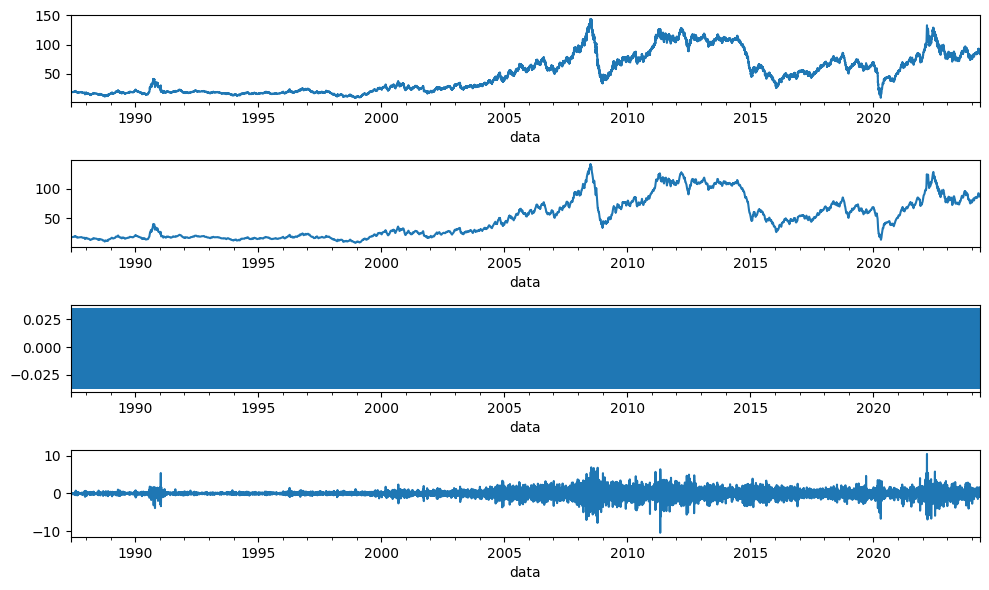

In [ ]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_eda)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

#### Analisando a decomposição da série temporal, podemos observar que:

- Tendência: Embora haja bastante variabilidade, é possível observar que a tendência é de alta.

- Sazonalidade: O gráfico nos mostra que não existe uma sazonalidade clara no comportamento do índice.

- Ruído: Percebemos ruídos em alguns momentos, que podem ter sido gerados devido o cenário economico da época (2009 com a Grande Recessão, por exemplo)